In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# importar callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# importar loadmodel
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

import matplotlib.pyplot as plt

import nltk 

from nltk.translate.bleu_score import corpus_bleu



In [2]:
# Importar archivo .csv
df = pd.read_csv('../File/df_corpus_linguistico_preprocesado.csv',
                 sep='\t', encoding='utf-8', index_col=0)
df.head()


,source,target,preprocess_source,preprocess_target
id,,,,
10151431,I always say that one of the most important th...,Siempre digo que una de las cosas más importan...,<start> i always say that one of the most impo...,<start> siempre digo que una de las cosas mas ...
5014881,Francis spent every night when he was outside ...,Francisco pasó todas las noches que estuvo fue...,<start> francis spent every night when he was ...,<start> francisco paso todas las noches que es...
9998244,Find Google- remove your Gmail account.,Encontrar Google- eliminar su cuenta de Gmail.,<start> find google remove your gmail account ...,<start> encontrar google eliminar su cuenta de...
11709695,"Anyways, apart from that the movie was finalized.","De todos modos, aparte de eso, la película fue...",<start> anyways apart from that the movie was ...,<start> de todos modos aparte de eso la pelicu...
5267593,Graphics Programming Black Book and the mindse...,El Libro Negro de la Programación Gráfica y la...,<start> graphics programming black book and th...,<start> el libro negro de la programacion graf...


In [3]:
df.shape

(100000, 4)

In [4]:
en_text = df['preprocess_source']
es_text = df['preprocess_target']


# Tokenizar frases


In [5]:
# Función para tokenizar el texto
def tokenization(lines):
    tokenizer = Tokenizer(num_words=10000)              
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [6]:
# Tokenizar el texto en inglés
en_tokenizer = tokenization(en_text)                   # num_words=10000 -> 10.000 palabras más frecuentes del corpus de inglés (source)
en_vocab_size = len(en_tokenizer.word_index) + 1

en_length = max(len(line.split()) for line in en_text)
print(f'English Vocabulary Size: {en_vocab_size}')
print(f'English Max Length: {en_length}')


English Vocabulary Size: 43725
English Max Length: 108


In [7]:
# Tokenizar el texto en español
es_tokenizer = tokenization(es_text)                   # num_words=10000 -> 10.000 palabras más frecuentes del corpus de español (target
es_vocab_size = len(es_tokenizer.word_index) + 1

es_length = max(len(line.split()) for line in es_text)
print(f'Spanish Vocabulary Size: {es_vocab_size}')
print(f'Spanish Max Length: {es_length}')

Spanish Vocabulary Size: 56158
Spanish Max Length: 109


## Gráfica de distribución de longitud de las frases

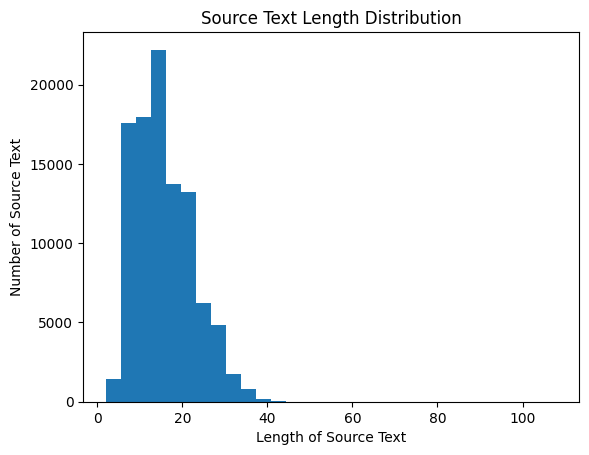

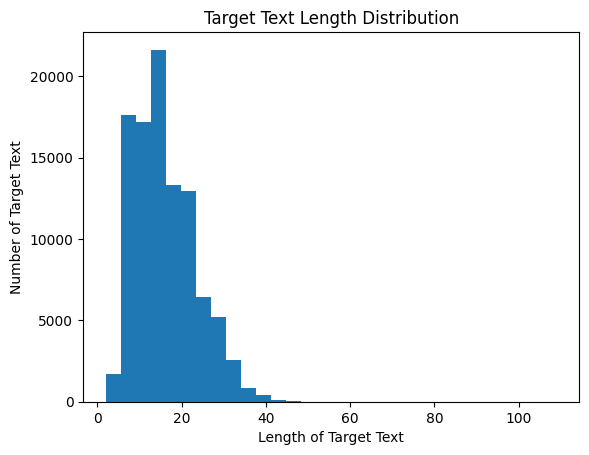

In [8]:
# Gráfica de distribución de longitud de las frases


length_en_text = [len(line.split()) for line in en_text]
length_es_text = [len(line.split()) for line in es_text]

plt.hist(length_en_text, bins=30)
# Etiquetas
plt.xlabel('Length of Source Text')
plt.ylabel('Number of Source Text')
plt.title('Source Text Length Distribution')
plt.show()

plt.hist(length_es_text, bins=30)
# Etiquetas
plt.xlabel('Length of Target Text')
plt.ylabel('Number of Target Text')
plt.title('Target Text Length Distribution')
plt.show()



Nota: 
Luego de representar gráficamente la distribución de la longitud de las frases, se observa una distribución sesgada hacia la derecha, por lo que se procede a truncar las frases a un máximo de 40 palabras.

In [9]:
en_length = 40
es_length = 40

## Gráfico con el total de palabras únicas de cada idioma en el corpus 

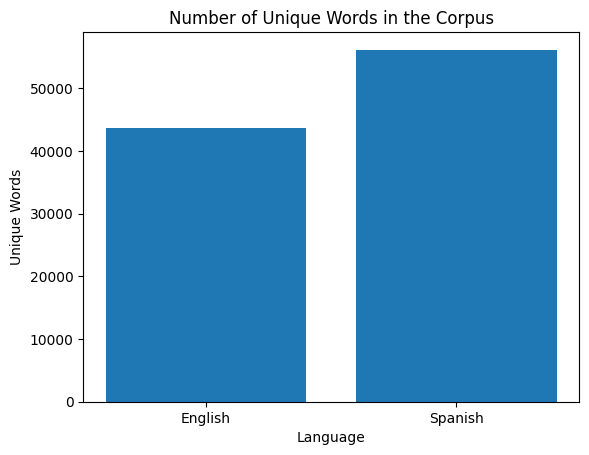

In [10]:

plt.bar(['English', 'Spanish'], [en_vocab_size, es_vocab_size])
# Etiquetas
plt.xlabel('Language')
plt.ylabel('Unique Words')
plt.title('Number of Unique Words in the Corpus')

plt.show()

Nota: 
Se puede observar que el número de palabras únicas en el corpus asciende a más de 40.000 palabras en ambos idiomas. Se decide tomar las 10.000 palabras más frecuentes en el corpus para reducir el tamaño del vocabulario y mejorar el rendimiento del modelo.


## Codificar secuencias de texto a entero

In [11]:

def encode_sequences(tokenizer, length, lines):
    # Entrenar el modelo de codificación
    seq = tokenizer.texts_to_sequences(lines)
    # Rellenar las secuencias con 0's para que tengan la misma longitud
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq


In [12]:
# Dividir el dataset en train y test

train, test = train_test_split(df, test_size=0.2, random_state=42)


In [13]:
# Codificar el texto en inglés
trainX = encode_sequences(en_tokenizer, en_length, train['preprocess_source'])
testX = encode_sequences(en_tokenizer, en_length, test['preprocess_source'])

# Codificar el texto en español
trainY = encode_sequences(es_tokenizer, es_length, train['preprocess_target'])
testY = encode_sequences(es_tokenizer, es_length, test['preprocess_target'])


## Definir el modelo

In [14]:
# Definir el modelo
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units,
              input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model


In [15]:
en_vocab_size = 10000
es_vocab_size = 10000

In [16]:

model = define_model(en_vocab_size, es_vocab_size, en_length, es_length, 128)


In [17]:

model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           131584    
                                                                 
 time_distributed (TimeDistr  (None, 40, 10000)        1290000   
 ibuted)                                                

In [19]:
filename = '../File/Model/model15.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history =  model.fit(trainX, trainY, 
                     
                     epochs=15, batch_size=256, validation_data=(testX, testY), callbacks=[checkpoint] , verbose=1)  



Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 2.1159 - accuracy: 0.6877
Epoch 1: val_loss improved from inf to 2.11655, saving model to ../File/Model/model15.h5
313/313 [==============================] - 386s 1s/step - loss: 2.1159 - accuracy: 0.6877 - val_loss: 2.1166 - val_accuracy: 0.6893
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 2.1034 - accuracy: 0.6888
Epoch 2: val_loss improved from 2.11655 to 2.10578, saving model to ../File/Model/model15.h5
313/313 [==============================] - 393s 1s/step - loss: 2.1034 - accuracy: 0.6888 - val_loss: 2.1058 - val_accuracy: 0.6881
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 2.0957 - accuracy: 0.6893
Epoch 3: val_loss improved from 2.10578 to 2.10429, saving model to ../File/Model/model15.h5
313/313 [==============================] - 867s 3s/step - loss: 2.0957 - accuracy: 0.6893 - val_loss: 2.1043 - val_accuracy: 0.6884
Epoch 4/15
313/313 [=====================

In [20]:
# Cargar el modelo
model = load_model('../File/Model/model15.h5')

## Evaluación del modelo

In [21]:
# Evaluar el modelo

score_train = model.evaluate(trainX, trainY)

print('Train loss:', score_train[0])        
print('Train accuracy:', score_train[1])

score_test = model.evaluate(testX, testY)

print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

2500/2500 [==============================] - 201s 80ms/step - loss: 1.8635 - accuracy: 0.7075
Train loss: 1.8635072708129883
Train accuracy: 0.7075477838516235
625/625 [==============================] - 70s 113ms/step - loss: 2.0009 - accuracy: 0.6933
Test loss: 2.0008528232574463
Test accuracy: 0.6932962536811829


### Gráfica sobre los valores de pérdida y presición del historial del modelo

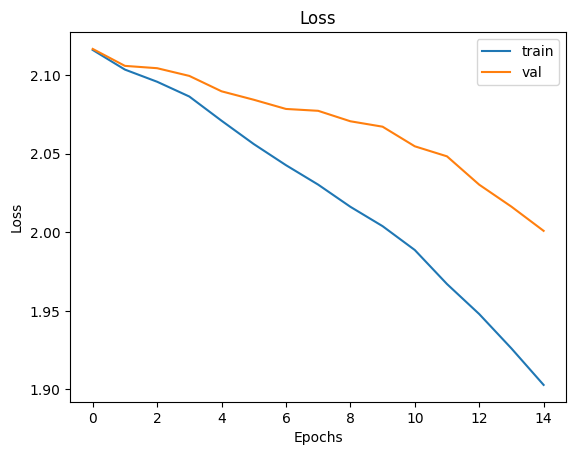

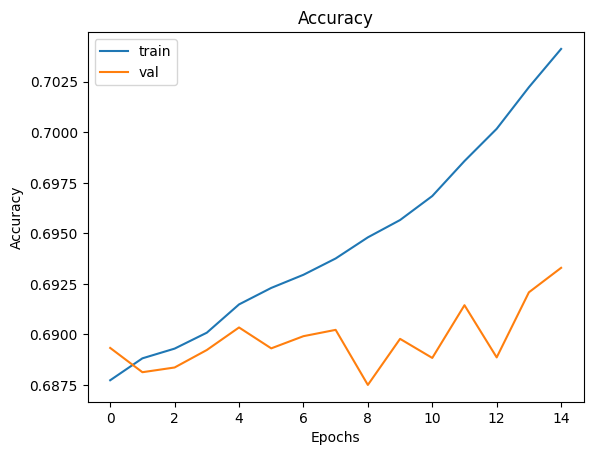

In [22]:
# Valores de pérdida y precisión del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Gráfica de la pérdida
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Gráfica de la precisión
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Predecir

In [23]:
# Función get_word

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [24]:
# Función para predecir una secuencia

def predict_sequence(model, input_sentence):
    inputs = []
    for i in input_sentence.split():
        if i in en_tokenizer.word_index:
            inputs.append(en_tokenizer.word_index[i])

    inputs = pad_sequences([inputs], maxlen=en_length, padding='post')

    temp = []
    for i in inputs[0]:
        t = get_word(i, es_tokenizer)
        if i > 0:
            if (t == get_word(i-1, es_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t == None):
                temp.append('')
            else:
                temp.append(t)

    print(' '.join(temp)) 

# Función para prededir varias secuencias
def predict_multiple_sequences(model, input_sentences):
    for i in input_sentences:
        predict_sequence(model, i)
        print('\n')


In [25]:
predict_sequence(model, 'i love you')

que estaba es                                     


In [26]:
test['preprocess_target'][30:40]

id
9195670                      <start> para el quad de ?  <end>
3353300           <start> avestruz y corral lo tengo .  <end>
5137219     <start> te da algo de estabilidad cuando tiene...
5759567     <start> sus canciones estan bien wrought y en ...
3761092     <start> a continuacion mi valoracion de las ca...
5158646     <start> queda muy bien con el banco de clavija...
3364697                     <start> la trufa blanca es  <end>
1190033     <start> no necesito estar comodo mientras el g...
11782773    <start> podria seguir durante mucho tiempo de ...
11375468    <start> wordpress es un sistema de gestion de ...
Name: preprocess_target, dtype: object

In [27]:
predict_multiple_sequences(model, test['preprocess_source'][30:40])


una de un tradicionalmente                                    


interactue y tocaba sea no                                   


pocos es sobre adivina tengo es las la dijeron y a solo una ligeramente por el bonitas un de jugador la meses mucho en de antes              


ya nuestra este estos oficios y por historia constantemente ya hice en alfiler gusto interminables ademas                        


puerta a como fuerza comedia                                   


hubiera solo me de toallas el juro barrios                                


de contenido promocional a                                    


que te se lugar la del queda mas leer mas de envio a nuestro                          


que cada parte por una altas tener pero no con hay los desde a                          


caracteristica a el equipo minimo sigue gente la tenian rango suelo                             


